# Argon A-to-Z

This tutorial aims to take the user from no familiarity with MDMC to enough competence that they can create a simple simulation and run a refinement, by walking through a simulation and refinement for the liquid argon data from [van Well et al. (1985)](https://doi.org/10.1103/PhysRevA.31.3391).  For more details on specific parts of this, please see the how-to guides!

If you'd like to learn more about a specific object, use the Python `help()` command - for example `help(Atom)` provides information on the MDMC `Atom`.

We first import all of the objects we require, and set some environmental variables.

In [1]:
import os
from MDMC.control import Control
from MDMC.MD import Atom, Dispersion, LennardJones, Simulation, Universe

# This setting tells MDMC how many simultaneous processes on your computer it should use
# for simulation and refinement calculations.
os.environ["OMP_NUM_THREADS"] = "4"

### Setting up a configuration and simulation

We now build our `Universe`. For this tutorial we're creating a cube of argon-36 atoms; our side length is 23.0668Å (angstrom), and the atoms fill it with a density of 0.0176 atoms per cubic angstrom. This simulation matches the experimental data that we'd like to refine against - you will see more about this below.

Atoms are created using MDMC `Atom` objects, and then the universe is filled with them via the `universe.fill` method.

In [2]:
universe = Universe(dimensions=23.0668)

Ar = Atom('Ar', charge=0., mass=36.0)
universe.fill(Ar, num_density=0.0176)

Universe created with:
Dimensions [23.07 23.07 23.07]


Note that at this point, there are no interaction forces between the argon atoms! The simulation doesn't know how these atoms should interact with each other. In the cell below an appropriate (for argon) force-field interaction potential is defined; we use a dispersive interaction with potential energy calculated by the [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential). This interaction has two parameters, epsilon and sigma, which determine the strength of the potential energy between atoms.

In [3]:
Ar_dispersion = Dispersion(universe,  # the universe our interaction applies to
                           (Ar.atom_type, Ar.atom_type),  # the types of atoms to which it applies (only one type here!)
                           cutoff=8.,  # the cutoff distance
                           function=LennardJones(epsilon=1.0243, sigma=3.36))  # the function which calculates the potential energy between two atoms

A `cutoff` distance, past which atoms do not interact, is chosen arbitrarily (see `help(Dispersion)` for more info). A [rule of thumb for Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential#Lennard-Jones_truncated_&_shifted_(LJTS)_potential) is to pick `cutoff=2.5*sigma`. The value for argon is recommended to be between 8 and 12 ang. Ideally, and for any system you want to pick at value of the `cutoff` which is small while not compromising accuracy. For this system, picking a value between 8 and 12 ang is found to give near identical results to the experimental data.

Next (and before starting the refinement), we set up the Simulation, which contains:
- the `Universe` that the simulation is based on;
- the MD engine used to run the simulations;
- the time-step in femtoseconds between each simulation frame; 
- the temperature of the Universe (used to calculate atom velocity);
- the trajectory step, which is how many time steps should occur for each 'step' of the refinement.

In [4]:
# MD Engine setup
simulation = Simulation(universe,
                        engine="lammps",
                        time_step=10.18893,
                        temperature=120.,
                        traj_step=15)

LAMMPS (29 Sep 2021 - Update 3)
LAMMPS output is captured by PyLammps wrapper
  using 4 OpenMP thread(s) per MPI task
LAMMPS (29 Sep 2021 - Update 3)
  using 4 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper
Total wall time: 0:00:00
using multi-threaded neighbor list subroutines


Simulation created with lammps engine and settings:
temperature: 120.0 K 




We then minimize and equilibrate the simulation; minimising the simulation avoids it getting 'stuck' in local minima, and equilibration runs the simulation until it reaches a state with a physically feasible temperature/energy distribution. This ensures our simulation isn't affected by the initial arrangement of the atoms.

In [5]:
# Energy Minimization and equilibration
simulation.minimize(n_steps=50)
simulation.run(n_steps=10000, equilibration=True)

### Refining our data

Our simulation is now fully set up. Now we need some data to which we fit our simulation; here we use an experimental [dynamic structure factor](https://en.wikipedia.org/wiki/Dynamic_structure_factor) $S(Q, \omega)$ for liquid argon. We call these dynamical properties an 'observable'.

In [6]:
# exp_datasets is a list of dictionaries with one dictionary per experimental
# dataset
# Dataset from: van Well et al. (1985). Physical Review A, 31(5), 3391-3414
# resolution is None as the original author already accounted for instrument resolution
exp_datasets = [{'file_name':'data/Well_s_q_omega_Ar_data.xml',
                 'type':'SQw',
                 'reader':'xml_SQw',
                 'weight':1.,
                 'auto_scale':True,
                 'resolution':800}]

We then need to create our parameters to fit against. In this case, we take all the universe parameters (which here are just the sigma and epsilon values that the Lennard-Jones potential depends on). Note that above when we set our initial `LennardJones` function in the `Dispersion` object, the epsilon and sigma were our "initial guesses" that the refinement will start from.

We also set constraints for our fitting parameters; we bound our sigma values to be between 2.8 and 3.8, and our epsilon to be between 0.6 and 1.4.

In [7]:
fit_parameters = universe.parameters
fit_parameters['sigma'].constraints = [2.7,3.8]
fit_parameters['epsilon'].constraints = [0.5, 1.5]

Now we create our `Control` object. This object oversees the refinement; it brings the simulation, dataset, and the fitting parameters together, and then does the following:
1. Run the simulation with the current parameters.
2. Calculate the simulated observable from the simulation trajectory.
3. Compare it to the experimental observable.
4. Use a minimizer (optimisation process) to refine the parameters, bringing them closer to the experimental observable.
5. Repeat with new parameters.

The minimizer we're using in this tutorial (see the parameter `minimizer_type`) uses a [Gaussian process optimiser](https://en.wikipedia.org/wiki/Gaussian_process). If you'd like to compare them, MDMC also provides the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) Monte Carlo algorithm, which you can select by setting `minimizer_type="MMC"`

In [8]:
control = Control(simulation=simulation,
                  exp_datasets=exp_datasets,
                  fit_parameters=fit_parameters,
                  minimizer_type="GPO",
                  reset_config=True,
                  MD_steps=4000,
                  equilibration_steps=4000,
                  data_printer='ipython')




The values (whilst prioritising time_step) have been changed to traj_step: 15, and time_step: 10.188949. 
Context: for this dataset, traj_step multiplied by time_step must be ~= 152.834237 (6 d.p). 



  warnings.warn("Assuming energy resolution is Gaussian. To change this,"



Control created with:
- Attributes                              -
  Minimizer                             GPO
  FoM type               ChiSquaredExpError
  Number of observables                   1
  Number of parameters                    2



Now that the dataset has been specified, and used to configure various processes and parameters, the system can be equilibrated.

In [9]:
# Energy Minimization and equilibration
control.minimize(n_steps=50)
control.equilibrate(n_steps=10000)

INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> minimize: {n_steps: 50, minimize_every: 10, etol: 0.0001, ftol: 0.0, maxiter: 10000, maxeval: 10000}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 10000, equilibration: True}


The number of `MD_steps` specified must be large enough to allow for statistically reasonable calculation of all observables. This depends the `type` of the dataset provided and the value of the `traj_step` (specified when creating the `Simulation`). If a value for `MD_steps` is not provided, then the minimum number needed will be used automatically.

Additionally, some observables will have an upper limit on the number of MD_steps that can be used in calculating their dependent variable(s). In these cases, the number of `MD_steps` is rounded down to a multiple of this upper limit so that we only run steps that will be useful. For example, if we use 1000 `MD_steps` in calculation, but a value of 2500 is provided, then we will run 2000 steps and use this to calculate the variable twice, without wasting time performing an additional 500 steps.

Finally, start the refinement! `n_steps` has been set to `25` just so you can see what a refinement looks like; it will take many more steps to fully refine a dataset. Bump it up to a higher number when you're ready. Results can also be plotted via the `control.plot_results` method.

,FoM,epsilon (#2),sigma (#3)
Step,,,
0,3834.152855,1.024300,3.360000
1,3834.162801,1.043844,3.505240
2,3834.157144,1.093889,2.815663
3,3834.289927,0.919516,3.780650
4,3834.168090,1.495079,3.436889
5,3834.171568,0.648673,2.783596
6,3834.144949,0.892343,3.137861
7,3834.181449,0.759477,3.681787
8,3834.145646,0.517653,3.217887


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 4000, equilibration: True}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> run: {n_steps: 3990, equilibration: False}


INFO:MDMC.MD.engine_facades.lammps_engine:<class 'MDMC.MD.engine_facades.lammps_engine.LAMMPSEngine'> save_config: {n_atoms: 216}. Config saved.


  verbose_manager.finish("Refinement")




The refinement has finished. 
 
Minimum measured point is: 
(0.8923434766016836 kJ / mol, 3.1378608239989343 Ang) with an FoM of 3834.1449494747267. 
 
Minimum point predicted is: 
(0.8923434766016836 kJ / mol, 3.1378608239989343 Ang) for an FoM of 3834.1449494747267.
 
 

Automatic Scale Factors
data/Well_s_q_omega_Ar_data.xml  1.368558e+15


Parameter means = [0.99825763 3.24869857], Parameter errors = [0.28726398 0.30748883]


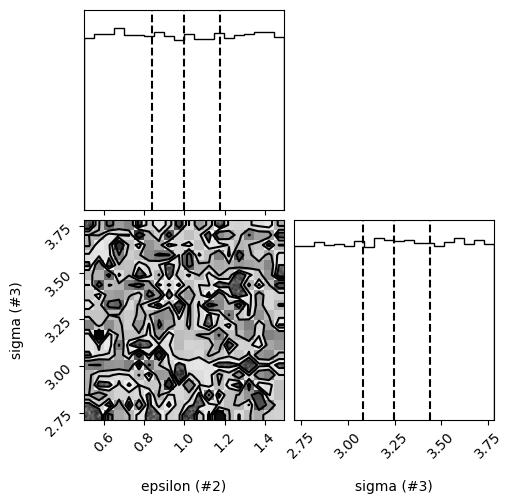

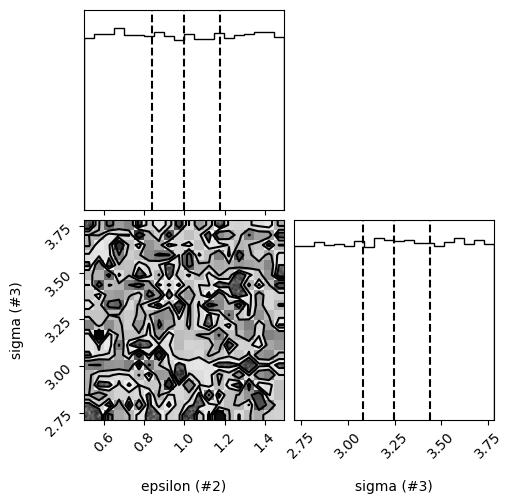

In [10]:
control.refine(n_steps=25)
control.plot_results()